<a href="https://colab.research.google.com/github/jmfdesouza/PUC_DataSciense/blob/main/PUC_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pontifícia Universidade Católica - PUC Rio de Janeiro

MVP Ciência de Dados: Análise de clientes de uma rede de shoppings

O objetivo deste estudo é analisar os padrões de compras de clientes em diferentes shoppings de uma rede, associando atributos como idade, gênero, categoria de produto e valor gasto, de modo que seja possível identificar padrões de consumo relativamente às categorias de produtos, formas de pagamento e comportamento demográfico dos clientes, viabilizando promover, por exemplo, uma campanha de marketing direcionada. Em tese, trata-se de um problema de aprendizado supervisionado, com o objetivo de prever o comportamento dos consumidores, possivelmente com foco em algum indicador constante das colunas, com base em informações demográficas e categorias de produtos.

Partindo de certas premissas, como que os dados sejam representativos do público dos shoppings, bem como que os mesmos sejam amplos, completos e consistentes, podemos formular algumas hipóteses passíveis de posterior validação, tais como se a idade e o gênero dos clientes influenciam suas preferências de categorias de produtos, e, igualmente, se o valor gasto pode estar relacionado a um dos shoppings em especial ou ao método de pagamento, e testando as já tradicionais análises sobre totais de vendas, entre unidades e produtos, a fim de se intensificar as campanhas de vendas de determinadas categorias de produtos, em diferentes unidades da rede, conforme as percepções apesentadas pelos números. Prosseguindo, vale ressaltar que tais dados foram coletados de clientes em diferentes shoppings da referida rede, e em diversas categorias de produtos adquiridos, de modo que a presente avaliação se restringe ao conjunto de atributos colecionados nas colunas do dataset em questão, quais sejam:

* invoice_no: Número da nota fiscal.

* customer_id: ID do cliente.

* gender: Gênero do cliente.

* age: Idade do cliente.

* category: Categoria de produto comprado (tipo de produto).

* quantity: Quantidade de produtos comprados.

* price: Preço total da compra.

* payment_method: Método de pagamento utilizado.

* invoice_date: Data da compra.

* shopping_mall: Shopping onde a compra foi efetuada.


In [ ]:
# Análise Exploratóratória

# Importando a biblioteca Pandas
import pandas as pd

# Carregando o dataset a partir de um link público disponibilizado no Google Drive
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRO9uQdx8esUmg7Lb1lo3pJpuTxJn2xFhGhBDv1Uf-fC0KSuANgCziJXKXuZcENKg/pub?output=xlsx"
shopping = pd.read_excel(url)

# Exibindo as 10 primeiras linhas do dataset
display(shopping.head(10))


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon
5,I227836,C657758,Female,28,Clothing,5,1500.40,Credit Card,24/05/2022,Forum Istanbul
6,I121056,C151197,Female,49,Cosmetics,1,40.66,Cash,13/03/2022,Istinye Park
7,I293112,C176086,Female,32,Clothing,2,600.16,Credit Card,13/01/2021,Mall of Istanbul
8,I293455,C159642,Male,69,Clothing,3,900.24,Credit Card,4/11/2021,Metrocity
9,I326945,C283361,Female,60,Clothing,2,600.16,Credit Card,22/08/2021,Kanyon


In [ ]:
# Estatísticas descritivas

# Verificando informações gerais sobre o dataset
shopping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [ ]:
# Verificando se há valores ausentes
shopping.isnull().sum()

,0
invoice_no,0
customer_id,0
gender,0
age,0
category,0
quantity,0
price,0
payment_method,0
invoice_date,0
shopping_mall,0


In [ ]:
# Exibindo estatísticas descritivas dos atributos numéricos
shopping.describe()

,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000


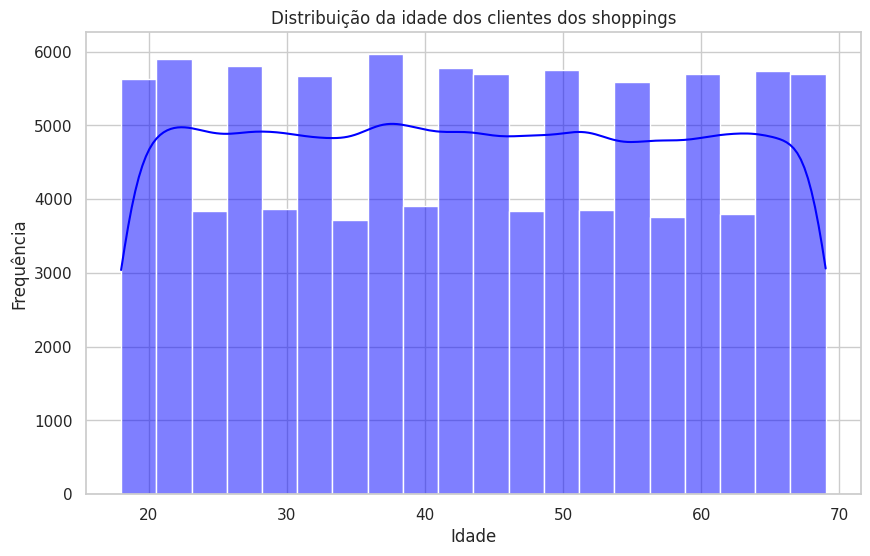

In [ ]:
# Visualização de informação: Distribuição de Atributos

# Importando as bibliotecas gráficas
import seaborn as sns
import matplotlib.pyplot as plt

# Configurando o estilo dos gráficos
sns.set(style="whitegrid")

# Histograma da distribuição de idade
plt.figure(figsize=(10,6))
sns.histplot(shopping["age"], bins=20, kde=True, color="blue")
plt.title("Distribuição da idade dos clientes dos shoppings")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()

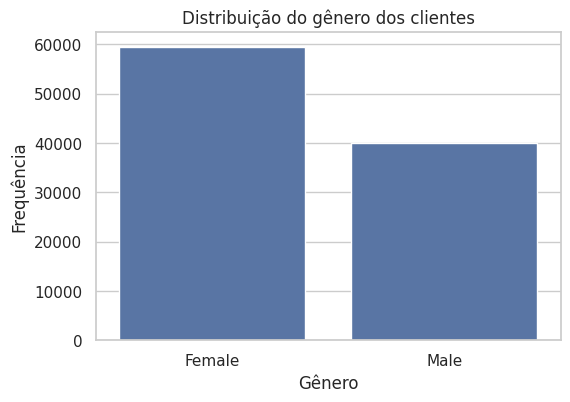

In [ ]:
# Gráfico de barras do gênero
plt.figure(figsize=(6,4))
sns.countplot(x="gender", data=shopping)
plt.title("Distribuição do gênero dos clientes")
plt.xlabel("Gênero")
plt.ylabel("Frequência")
plt.show()


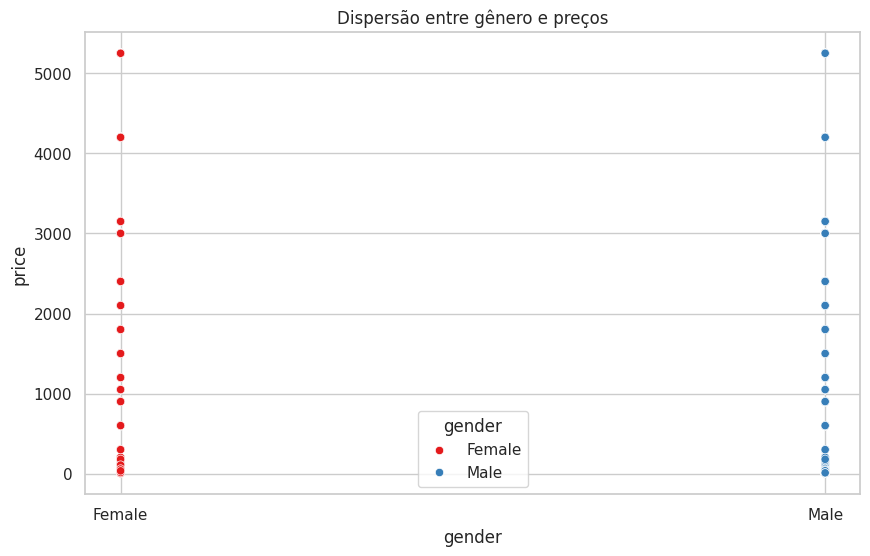

In [ ]:
# Dispersão entre Gênero e Preços (Consumo)
plt.figure(figsize=(10,6))
sns.scatterplot(x="gender", y="price", data=shopping, hue="gender", palette='Set1')
plt.title("Dispersão entre gênero e preços")
plt.xlabel("gender")
plt.ylabel("price")
plt.show()

In [ ]:
# Pré-processamento de dados
# Normalização (variáveis numéricas)

from sklearn.preprocessing import MinMaxScaler

# Separarando as colunas numéricas
colunas_numericas = ["age", "quantity", "price"]

# Inicializando o MinMaxScaler
scaler = MinMaxScaler()

# Aplicando o scaler nas colunas numéricas
shopping[colunas_numericas] = scaler.fit_transform(shopping[colunas_numericas])

# Verificando os resultados da normalização
print(shopping.head())


  invoice_no customer_id  gender       age  category  quantity     price  \
0    I138884     C241288  Female  0.196078  Clothing      1.00  0.285078   
1    I317333     C111565    Male  0.058824     Shoes      0.50  0.342299   
2    I127801     C266599    Male  0.039216  Clothing      0.00  0.056218   
3    I173702     C988172  Female  0.941176     Shoes      1.00  0.571163   
4    I337046     C189076  Female  0.686275     Books      0.75  0.010557   

  payment_method invoice_date   shopping_mall  
0    Credit Card     5/8/2022          Kanyon  
1     Debit Card   12/12/2021  Forum Istanbul  
2           Cash    9/11/2021       Metrocity  
3    Credit Card   16/05/2021    Metropol AVM  
4           Cash   24/10/2021          Kanyon  


In [ ]:
# Transformação de variáveis categóricas (One-Hot Encoding)

# Separarando colunas por tipo
colunas_identificadores = ["invoice_no", "customer_id"]
colunas_categoricas = ["gender", "category", "payment_method", "shopping_mall"]
colunas_numericas = ["age", "quantity", "price"]

# 1. Aplicando One-Hot Encoding nas colunas categóricas
shopping_encoded = pd.get_dummies(shopping, columns=colunas_categoricas, drop_first=True)

# 2. Normalizando colunas numéricas
scaler = MinMaxScaler()
shopping_encoded[colunas_numericas] = scaler.fit_transform(shopping_encoded[colunas_numericas])

# Verificando o dataset com as transformações
print(shopping_encoded.head())


  invoice_no customer_id       age  quantity     price invoice_date  \
0    I138884     C241288  0.196078      1.00  0.285078     5/8/2022   
1    I317333     C111565  0.058824      0.50  0.342299   12/12/2021   
2    I127801     C266599  0.039216      0.00  0.056218    9/11/2021   
3    I173702     C988172  0.941176      1.00  0.571163   16/05/2021   
4    I337046     C189076  0.686275      0.75  0.010557   24/10/2021   

   gender_Male  category_Clothing  category_Cosmetics  \
0        False               True               False   
1         True              False               False   
2         True               True               False   
3        False              False               False   
4        False              False               False   

   category_Food & Beverage  ...  payment_method_Debit Card  \
0                     False  ...                      False   
1                     False  ...                       True   
2                     False  ...         

In [ ]:
# Analisando a movimentação de vendas (consumo total dos clientes)

total_vendas = shopping.price.sum()

display(total_vendas)

12971.246746759152

In [ ]:
# Analisando a movimentação de vendas (por shopping da rede)

total_shopping = shopping[["price", "shopping_mall"]].groupby("shopping_mall").sum()
display(total_shopping)

,price
shopping_mall,
Cevahir AVM,649.707978
Emaar Square Mall,641.638581
Forum Istanbul,631.143217
Istinye Park,1270.965726
Kanyon,2594.409469
Mall of Istanbul,2621.170372
Metrocity,1939.355308
Metropol AVM,1312.707890
Viaport Outlet,646.037718


In [ ]:
# Analisando a movimentação de vendas (categoria)

total_categoria = shopping[["price", "category"]].groupby("category").sum()
display(total_categoria)

,price
category,
Books,38.309911
Clothing,5890.690656
Cosmetics,337.412239
Food & Beverage,29.417921
Shoes,3447.788763
Souvenir,28.274273
Technology,3002.213809
Toys,197.139175


In [ ]:
# Analisando a movimentação de vendas (por shopping e categoria)

total_cat_shopp = shopping[["price", "shopping_mall", "category"]].groupby(["shopping_mall", "category"]).sum()
display(total_cat_shopp)

price
shopping_mall category                   
Cevahir AVM   Books              2.030491
              Clothing         294.650048
              Cosmetics         16.123963
              Food & Beverage    1.516717
              Shoes            168.069851
...                                   ...
Zorlu Center  Food & Beverage    1.461872
              Shoes            181.315055
              Souvenir           1.345068
              Technology       152.903273
              Toys               9.916326

[80 rows x 1 columns]

Análise geral, com as principais percepções sobre os dados apresentados:

A distribuição de idade dos clientes, normalizada entre 0 e 1, mostra uma certa uniformidade, sem picos ou padrões muito evidentes, porém, há uma leve concentração de clientes nas extremidades inferior e superior da faixa de idade, com a qual podemos concluir que existe uma preferência de clientes mais jovens ou mais velhos, a depender do shopping frequentado da rede. Por sua vez, a dispersão de preços entre os gêneros sugere que não há uma diferença relevante nos padrões de consumo entre homens e mulheres, sendo que ambos registram suas transações de forma semelhante ao longo da faixa de preços, com alguns outliers que revelam transações envolvendo valores mais volumosos, para ambos os sexos.

Do ponto de vista de facilidade, podemos verificar que a base de dados não apresenta valores ausentes, o que abrevia o processo de análise e modelagem, posto que não se requer maiores esforços para o tratamento de dados faltantes.

Outra observação possível é que a idade dos clientes varia uniformemente dentro do intervalo de 0 a 1 após normalização, indicando que a população de clientes possui uma distribuição razoável entre as várias idades, e acrescentando, vale destacar também que as colunas "quantity" e "price" podem ser confrontadas para entender se há uma relação entre a quantidade de produtos adquiridos e o valor total gasto, o que pode fornecer insights sobre o comportamento de consumo dos clientes.

Já abordando os aspectos mais tradicionais de avaliação, considerando os valores antes da normalização das colundas numéricas, para que fique mais clara visualmente essa parte da análise, é fácil notar que há três unidades que se destacam em volume de vendas totais, a saber, Mall of Istanbul	com 13.851.737,62 de unidades monetárias, seguido por Kanyon, com 13.710.755.24 e Metrocity	10.249.980,07. Entre as categorias de produtos, há uma sem concorrência: Clothing	(roupas) com impressionantes 31.075.684,64 de unidades monetárias.

Com tudo isso, pode-se considerar que esta base de dados encontra-se preparada para ser utilizada nas próximas etapas do processo de Ciência de Dados, como aplicação de algoritmo de machine learning, a fim de ser útil nos mecanismos de propaganda e marketing, com potencial de agregar valor à rede de shoppings, aumentando as vendas por categoria, unidade a unidade da rede.